In [1]:
#import basic libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt, matplotlib.gridspec as gridspe
import seaborn as sns
import polars as pl

import optuna
import os
from multiprocessing import Pool, cpu_count
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy.optimize import minimize

# I. Data Exploratory Analysis (EDA) & Data Prepossessing 

## 1. Data Loading

In [2]:
dic = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv")
train_df = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/train.csv")
test_df = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/test.csv")

##  2. Data Preview

### 2.1. Preview Data_dictionary
The HBN dataset has total 11 instruments. Each one are presented by some fields calculated below. The total number of fields collected is 80 (excluding id).

In [3]:
# Preview data_dictionary
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None) 
dic.head()

,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN


In [4]:
# Summarise data_dictionary
# grouped = dic.groupby('Instrument', sort=False)['Field'].apply(lambda x: ', '.join(x)).reset_index()
# grouped['NumFields'] = dic.groupby('Instrument', sort=False).size().values
# grouped = grouped.style.set_properties(**{'text-align': 'left'}, subset=['Instrument', 'Field', 'NumFields']) \
    # .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}])

# grouped

### 2.2. Preview Train & Test data

In [5]:
# training data
# train_df.info()

2736 non-null in sii => 
sii missing is about 30% (accepted to remove), so only use part with sii valid to train the supervised model for accurately.

In [6]:
usable_train_df = train_df.dropna(subset='sii')
# usable_train_df.info()

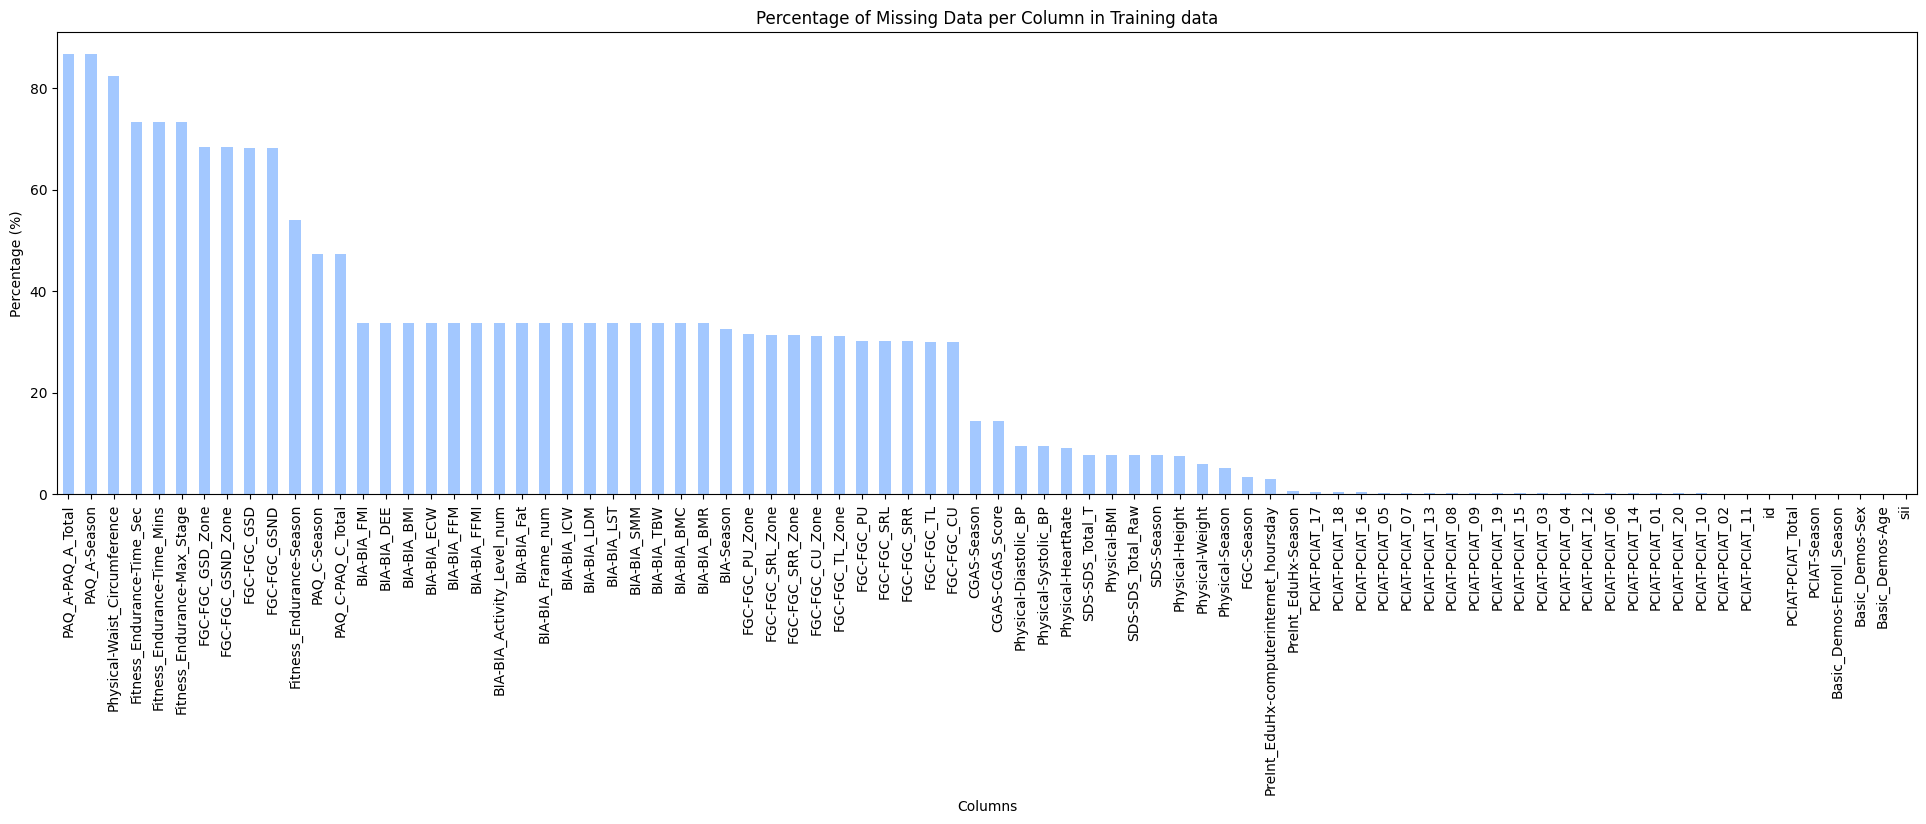

In [7]:
missing_percentage = (usable_train_df.isnull().sum() / len(usable_train_df)) * 100 # calculate % missing data

missing_percentage.sort_values(ascending=False).plot(kind='bar', color='#A3C8FF', figsize=(24, 6))
plt.title('Percentage of Missing Data per Column in Training data')
plt.ylabel('Percentage (%)')
plt.xlabel('Columns');

In [8]:
#Testing data
# test_df.info()
# 58 fields measured (excluding id) 

In [9]:
# missing_percentage_test = (test_df.isnull().sum() / len(test_df)) * 100 # calculate % missing data

# missing_percentage_test.sort_values(ascending=False).plot(kind='bar', color='orange', figsize=(24, 6))
# plt.title('Percentage of Missing Data per Column in Testing data')
# plt.ylabel('Percentage (%)')
# plt.xlabel('Testing data');

In [10]:
# find the difference between 2 files
# print([f for f in train_df.columns if f not in test_df.columns])
# columns_train = set(usable_train_df.columns)
# columns_test = set(test_df.columns)
# difference = sorted(list(columns_train - columns_test)) #Find the difference columns in 2 data files
# print(difference) # 23

### 2.3. Features Classification

In [11]:
# Identify the type of fields (features to train)
# def print_column_info(column_type, column_name):
    #cols = dic[dic['Type'] == column_type]['Field']
    #print(f"{column_name}: {len(cols)}")
    #print(cols.values)
    #print("\n")

# print_column_info('float', 'Continuous')
# print_column_info('int', 'Discrete')
# print_column_info('str', 'Categorical')
# print_column_info('categorical int', 'Categorical Int')


### 2.4. Distribution of features

In [12]:
# Distribution of numerical features
# usable_train_df.describe()

In [13]:
#categorical features
# usable_train_df.select_dtypes(include=["object"]).describe()

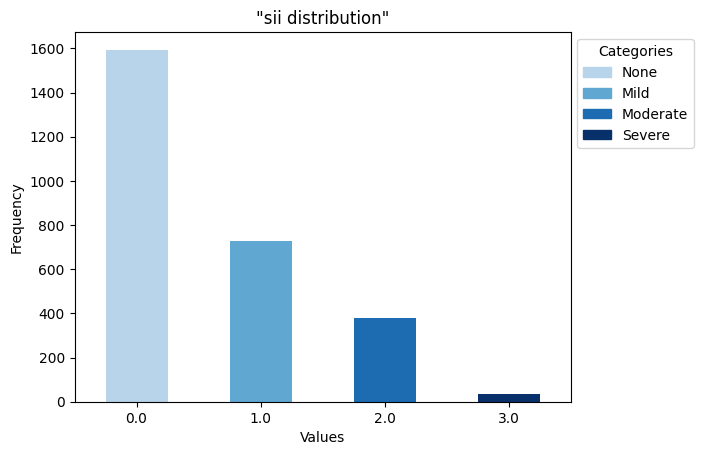

In [14]:
# sii distribution → sii is imbalanced, half of it is 0
sii_counts = usable_train_df['sii'].value_counts()
colors = plt.cm.Blues(np.linspace(0.3, 1, len(sii_counts)))

#plt.figure(figsize=(12, 6))
sii_counts.plot(kind='bar', color=colors)
plt.title('"sii distribution"')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
legend_labels = ['None', 'Mild', 'Moderate', 'Severe']
colors_for_legend = colors
plt.legend(handles=[plt.Rectangle((0, 0), 1, 1, color=color) for color in colors_for_legend],
           labels=legend_labels, title="Categories", loc='upper left', bbox_to_anchor=(1, 1));


## EDA


### 2.1. Encode Season columns

In [15]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
columns_to_encode = [
    'Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season',
    'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season',
    'PAQ_C-Season', 'PCIAT-Season', 'SDS-Season', 'PreInt_EduHx-Season'
]

for col in columns_to_encode:
    encoder = LabelEncoder()
    non_null_values = train_df[col].dropna().astype(str)
    encoder.fit(non_null_values)
    train_df[col] = train_df[col].map(lambda x: encoder.transform([str(x)])[0] if pd.notna(x) else np.nan)

test_col_to_encode = [col for col in columns_to_encode if col != 'PCIAT-Season']

for col in test_col_to_encode:
    test_df[col] = test_df[col].map(lambda x: encoder.transform([str(x)])[0] if pd.notna(x) else np.nan)

usable_train_df = train_df.dropna(subset=['sii'])

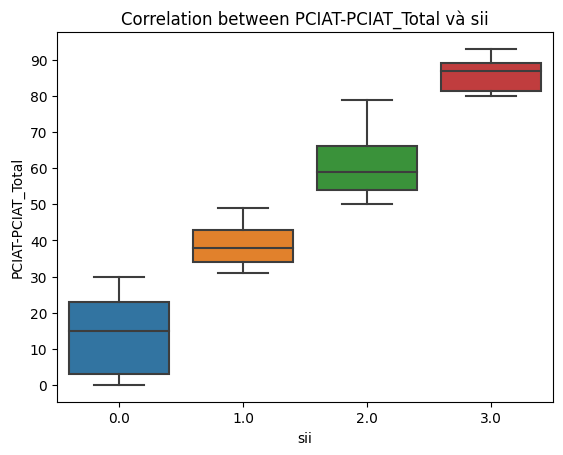

In [16]:
sns.boxplot(x='sii', y='PCIAT-PCIAT_Total', data=usable_train_df)
plt.title('Correlation between PCIAT-PCIAT_Total và sii')
plt.xlabel('sii')
plt.ylabel('PCIAT-PCIAT_Total')
y_ticks = np.arange(usable_train_df['PCIAT-PCIAT_Total'].min(), usable_train_df['PCIAT-PCIAT_Total'].max(), 10)
plt.yticks(y_ticks);

The target ```sii``` is available exactly for those participants for whom we have results of the Parent-Child Internet Addiction Test (PCIAT), and it is a function of the PCIAT total score.
* 0-30 Normal (0)
* 31-49 Mild (1)
* 50-79 Moderate (2)
* 80-100 Severe (3)

Proof: https://digitalwellnesslab.org/wp-content/uploads/Scoring-Overview.pdf

Basic_Demos-Age                           0.409559
Physical-BMI                              0.240858
Physical-Height                           0.420765
Physical-Weight                           0.353048
FGC-FGC_GSND                              0.146813
FGC-FGC_GSD                               0.160472
FGC-FGC_SRL                              -0.091221
FGC-FGC_SRR                              -0.077836
BIA-BIA_BMI                               0.248060
BIA-BIA_DEE                               0.053094
BIA-BIA_FFMI                              0.109694
BIA-BIA_FMI                               0.085863
BIA-BIA_ICW                               0.052593
BIA-BIA_LST                               0.075623
BIA-BIA_SMM                               0.052912
CGAS-CGAS_Score                          -0.070542
Physical-Waist_Circumference              0.327013
Physical-Diastolic_BP                     0.069321
Physical-Systolic_BP                      0.147081
Fitness_Endurance-Time_Mins    

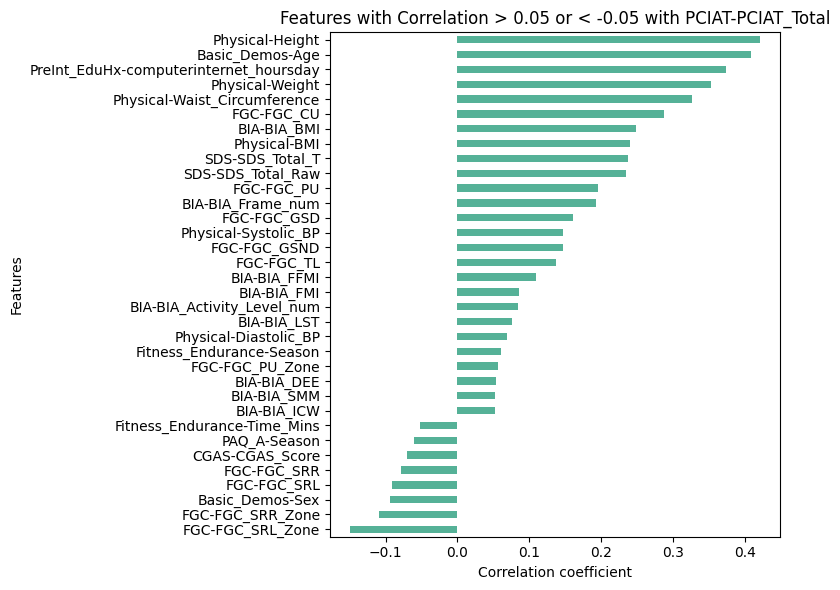

In [17]:
# Check correlation between numerical features and PCIAT Total Scores

corr_matrix = usable_train_df[[
    'Basic_Demos-Age', 'Physical-BMI', 'Physical-Height', 'Physical-Weight',
 'FGC-FGC_GSND' ,'FGC-FGC_GSD', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'BIA-BIA_BMC',
 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE' ,'BIA-BIA_ECW', 'BIA-BIA_FFM',
 'BIA-BIA_FFMI' ,'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_ICW' ,'BIA-BIA_LDM',
 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total',
 'PAQ_C-PAQ_C_Total', 'CGAS-CGAS_Score' ,'Physical-Waist_Circumference', 'Physical-Diastolic_BP',
 'Physical-HeartRate', 'Physical-Systolic_BP' ,'Fitness_Endurance-Max_Stage',
 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec' ,'FGC-FGC_CU',
 'FGC-FGC_PU', 'FGC-FGC_TL' ,'PCIAT-PCIAT_Total', 'SDS-SDS_Total_Raw',
 'SDS-SDS_Total_T', 'PreInt_EduHx-computerinternet_hoursday',
    
    'Basic_Demos-Sex', 'FGC-FGC_CU_Zone' ,'FGC-FGC_GSND_Zone',
 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone' ,'FGC-FGC_SRL_Zone',
 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num',
 'BIA-BIA_Frame_num', 
    
    'Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season',
    'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season',
    'PAQ_C-Season', 'PCIAT-Season', 'SDS-Season', 'PreInt_EduHx-Season'
]].corr()

sii_corr = corr_matrix['PCIAT-PCIAT_Total'].drop('PCIAT-PCIAT_Total')
filtered_corr = sii_corr[(sii_corr > 0.05) | (sii_corr < -0.05)]

print(filtered_corr)

plt.figure(figsize=(8, 6))
filtered_corr.sort_values().plot(kind='barh', color='#55B197')
plt.title('Features with Correlation > 0.05 or < -0.05 with PCIAT-PCIAT_Total')
plt.xlabel('Correlation coefficient')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# II. Feature Engineering

### 2.2. Handle Actigraphy data

In [18]:
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path

# Function to process a single file
def process_file(filename, dirname):
    filepath = Path(dirname) / filename / 'part-0.parquet'
    df = pd.read_parquet(filepath)
    df = df.drop(columns='step') 
    return df.describe().values.reshape(-1), filename.split('=')[1]

# Function to load and process all files in parallel
def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    num_threads = min(len(ids), 
                      os.cpu_count() * 4) # add more CPU
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    stats, indexes = zip(*results)
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

# AutoEncoder class
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim * 3), nn.ReLU(),
            nn.Linear(encoding_dim * 3, encoding_dim * 2), nn.ReLU(),
            nn.Linear(encoding_dim * 2, encoding_dim), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim * 2), nn.ReLU(),
            nn.Linear(input_dim * 2, input_dim * 3), nn.ReLU(),
            nn.Linear(input_dim * 3, input_dim), nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Function to train and use the AutoEncoder
def autoencode_data(df, encoding_dim=50, epochs=50, batch_size=32):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    data_tensor = torch.FloatTensor(df_scaled)
    input_dim = data_tensor.shape[1]
    
    autoencoder = AutoEncoder(input_dim, encoding_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

    for epoch in range(epochs):
        for i in range(0, len(data_tensor), batch_size):
            batch = data_tensor[i:i + batch_size]
            optimizer.zero_grad()
            loss = criterion(autoencoder(batch), batch)
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

    with torch.no_grad():
        encoded_data = autoencoder.encoder(data_tensor).numpy()

    return pd.DataFrame(encoded_data, columns=[f'Acti_{i + 1}' for i in range(encoded_data.shape[1])])

In [19]:
#read
train_acti = load_time_series('/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet')
test_acti = load_time_series('/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet')

#encode
train_ts = autoencode_data(train_acti.drop('id', axis=1))
test_ts = autoencode_data(test_acti.drop('id', axis=1))

train_ts['id'] = train_acti['id']
test_ts['id'] = test_acti['id']

100%|██████████| 2/2 [00:00<00:00,  8.38it/s]


Epoch [10/50], Loss: 1.5819
Epoch [20/50], Loss: 1.4838
Epoch [30/50], Loss: 1.4536
Epoch [40/50], Loss: 1.4412
Epoch [50/50], Loss: 1.4389
Epoch [10/50], Loss: 1.0360
Epoch [20/50], Loss: 0.7628
Epoch [30/50], Loss: 0.4398
Epoch [40/50], Loss: 0.4271
Epoch [50/50], Loss: 0.4271


### 2.1 Feature selection

In [20]:
# choose features with high correlation
featuresCols = [
    'Basic_Demos-Age', 'Physical-BMI', 'Physical-Height', 'Physical-Weight',
    'FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'BIA-BIA_BMC',
    'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
    'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM',
    'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total',
    'PAQ_C-PAQ_C_Total', 'CGAS-CGAS_Score', 'Physical-Waist_Circumference',
    'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
    'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins',
    'Fitness_Endurance-Time_Sec', 'FGC-FGC_CU', 'FGC-FGC_PU', 'FGC-FGC_TL',
    'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 'Basic_Demos-Enroll_Season',
    'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season',
    'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season',
    'PreInt_EduHx-Season', 'Basic_Demos-Sex', 'FGC-FGC_CU_Zone',
    'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone',
    'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone',
    'BIA-BIA_Activity_Level_num', 'BIA-BIA_Frame_num',
    'PreInt_EduHx-computerinternet_hoursday'
]

In [21]:
#filter features has >50% missing data
columns_with_missing = missing_percentage[missing_percentage > 50].index
missCols = usable_train_df[columns_with_missing]
# print(missCols)

selectedFeatures = list(set(featuresCols) - set(missCols))
selected_df = usable_train_df[["id"] + [col for col in selectedFeatures if col != "id"]]

test = test_df[["id"]+ selectedFeatures]
# test.head()

In [22]:
selected_df.shape

(2736, 48)

In [23]:
selected_df = selected_df.merge(train_ts, on='id', how='left')
test = test.merge(test_ts, on='id', how='left')

In [24]:
selected_df = selected_df.drop(columns='id')

In [25]:
selected_df.shape


(2736, 97)

### 2.2. Handle missing data

In [26]:
from sklearn.experimental import enable_iterative_imputer  # Cần import trước khi sử dụng IterativeImputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(max_iter=25, random_state=42)

selected_df = pd.DataFrame(imputer.fit_transform(selected_df), columns=selected_df.columns)

selected_df.head()


,Basic_Demos-Enroll_Season,BIA-BIA_LDM,FGC-FGC_SRR_Zone,Physical-BMI,BIA-BIA_FFMI,CGAS-Season,PreInt_EduHx-computerinternet_hoursday,PreInt_EduHx-Season,FGC-Season,FGC-FGC_SRR,Physical-Height,SDS-SDS_Total_Raw,FGC-FGC_PU_Zone,BIA-BIA_Frame_num,BIA-BIA_BMC,BIA-BIA_ECW,FGC-FGC_SRL,BIA-BIA_BMI,BIA-BIA_SMM,FGC-FGC_TL_Zone,FGC-FGC_PU,SDS-Season,FGC-FGC_CU_Zone,FGC-FGC_CU,PAQ_C-Season,BIA-BIA_Activity_Level_num,BIA-BIA_TBW,BIA-BIA_Fat,Physical-HeartRate,BIA-BIA_ICW,FGC-FGC_TL,Physical-Weight,Physical-Diastolic_BP,SDS-SDS_Total_T,BIA-BIA_LST,PAQ_C-PAQ_C_Total,BIA-BIA_FFM,FGC-FGC_SRL_Zone,Physical-Season,BIA-Season,BIA-BIA_DEE,BIA-BIA_FMI,CGAS-CGAS_Score,Basic_Demos-Age,Physical-Systolic_BP,BIA-BIA_BMR,Basic_Demos-Sex,Acti_1,Acti_2,Acti_3,Acti_4,Acti_5,Acti_6,Acti_7,Acti_8,Acti_9,Acti_10,Acti_11,Acti_12,Acti_13,Acti_14,Acti_15,Acti_16,Acti_17,Acti_18,Acti_19,Acti_20,Acti_21,Acti_22,Acti_23,Acti_24,Acti_25,Acti_26,Acti_27,Acti_28,Acti_29,Acti_30,Acti_31,Acti_32,Acti_33,Acti_34,Acti_35,Acti_36,Acti_37,Acti_38,Acti_39,Acti_40,Acti_41,Acti_42,Acti_43,Acti_44,Acti_45,Acti_46,Acti_47,Acti_48,Acti_49,Acti_50
0,0.0,8.895360,0.0,16.877316,13.817700,3.00000,3.0,0.0,0.0,6.0,46.0,40.962255,0.0,1.000000,2.668550,8.255980,7.0,16.879200,19.541300,1.0,0.0,0.387999,0.0,0.0,1.350993,2.000000,32.690900,9.213770,85.512193,24.434900,6.0,50.8,67.719928,57.717151,38.917700,2.560461,41.586200,0.0,0.0,0.000000,1492.00000,3.061430,51.000000,5.0,110.760315,932.498000,0.0,2.371302,2.204271,0.741937,2.430499,1.135320,2.823047,2.193579,2.049319,2.044759,0.0,2.177578,2.136674,2.063965,1.315162,3.983250,2.954295,2.617017,2.581917,1.439547,1.970774,3.206585,0.799311,3.338684,2.477951,1.749600,2.310194,2.465675,0.0,0.824090,4.244413,1.428741,1.932217,2.366533,0.0,1.587565,1.709522,1.892256,0.0,1.490066,1.960870,1.469403,1.468825,1.701122,-0.019461,2.773806,0.837694,1.877252,1.667284,2.702627,1.637669
1,2.0,14.974000,1.0,14.035590,12.825400,1.83542,0.0,2.0,0.0,11.0,48.0,46.000000,0.0,1.000000,2.579490,6.019930,11.0,14.037100,15.410700,0.0,5.0,0.000000,0.0,3.0,0.000000,2.000000,27.055200,3.970850,70.000000,21.035200,3.0,46.0,75.000000,64.000000,39.449700,2.340000,42.029100,1.0,0.0,3.000000,1498.65000,1.211720,62.465118,9.0,122.000000,936.656000,0.0,2.017360,2.393840,0.803811,2.431623,0.711339,2.793552,2.190935,2.288114,2.010514,0.0,1.831830,2.159999,2.041181,1.393234,4.036896,3.117865,2.452304,2.363103,1.710067,1.945744,3.172153,0.983580,3.360121,2.413057,1.762583,2.310430,2.314536,0.0,0.845225,4.191346,1.741377,1.961707,2.513235,0.0,1.439690,1.761817,1.881282,0.0,1.396904,1.963272,1.423078,1.234440,1.465941,0.020605,2.697787,0.834818,1.885843,1.461921,2.730503,2.078413
2,2.0,20.061133,1.0,16.648696,14.992029,0.00000,2.0,2.0,0.0,10.0,56.5,38.000000,1.0,1.632526,6.954503,20.781974,10.0,19.232347,42.120873,0.0,7.0,0.000000,1.0,20.0,2.000000,2.618355,53.916501,6.067033,94.000000,33.134537,5.0,75.6,65.000000,54.000000,67.023128,2.170000,73.977642,1.0,0.0,0.418321,1960.49561,4.240321,71.000000,10.0,117.000000,1236.603695,1.0,2.399428,2.189401,0.923907,2.488415,0.823570,2.787074,2.087960,2.281144,2.116669,0.0,1.900579,2.162174,2.099095,1.341854,3.816201,3.056359,2.445038,2.359810,1.646966,1.875077,3.153235,0.801226,3.462996,2.693645,1.520530,2.367917,2.485722,0.0,0.691110,4.284388,1.553786,2.054303,2.338208,0.0,1.426598,1.889891,1.910200,0.0,1.494945,1.877140,1.438473,1.153361,1.399918,0.047368,2.652763,0.811285,1.816187,1.786654,2.738621,2.066104
3,3.0,16.779000,0.0,18.292347,14.074000,0.00000,0.0,3.0,2.0,7.0,56.0,31.000000,0.0,2.000000,3.841910,15.592500,7.0,18.294300,26.479800,1.0,5.0,2.000000,1.0,18.0,3.000000,3.000000,45.996600,18.824300,97.000000,30.404100,7.0,81.6,60.000000,45.000000,58.933800,2.451000,62.775700,0.0,2.0,2.000000,1923.44000,4.220330,71.000000,9.0,117.000000,1131.430000,0.0,3.942833,1.915455,2.344585,1.860566,0.000000,2.268952,0.728013,2.866467,0.000000,0.0,1.336872,2.707453,2.280937,0.000000,3.515925,2.026621,4.340713,3.517400,2.641675,1.533711,2.013048

# III. Model training

### Model

```
Params_LGB = {
   'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,  # Increased from 6.59
    'lambda_l2': 0.01,
    'verbose': -1
}

XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,
    'reg_lambda': 5,
    'random_state': 0,
    'tree_method': 'hist',  
}

CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': 0,
    'verbose': 0,
    'l2_leaf_reg': 10,
    'task_type': 'CPU' 
}
```

In [27]:
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

In [28]:
def optimize_model_params(model_name, X, y):
    def objective(trial):
        if model_name == 'lgb':
            params = {
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.046),
                'max_depth': trial.suggest_int('max_depth', 3, 12),
                'num_leaves': trial.suggest_int('num_leaves', 20, 478),
                'n_estimators': trial.suggest_int('n_estimators', 50, 200),
                'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 13),
                'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 0.893),
                'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 0.784),
                'bagging_freq': trial.suggest_int('bagging_freq', 1, 4),
                'lambda_l1': trial.suggest_float('lambda_l1', 0, 10),
                'lambda_l2': trial.suggest_float('lambda_l2', 0,0.01),
                'verbose': -1,
            }
            model = lgb.LGBMRegressor(**params)

        elif model_name == 'xgb':
            params = {
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
                'max_depth': trial.suggest_int('max_depth', 3, 6),
                'n_estimators': trial.suggest_int('n_estimators', 50,200),
                'subsample': trial.suggest_float('subsample', 0.5, 0.8),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 10, ),
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
                'random_state': 0,
                'tree_method': 'hist',  
            }
            model = xgb.XGBRegressor(**params)

        elif model_name == 'catboost':
            params = {
                'learning_rate': trial.suggest_float('learning_rate', 0.01,0.05),
                'depth': trial.suggest_int('depth', 4,6),
                'iterations': trial.suggest_int('iterations', 50,200),
                'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1,10),
                'random_seed': 0,
                'verbose': 0,
                'task_type': 'CPU',
            }
            model = cb.CatBoostRegressor(**params)

        else:
            raise ValueError("Unsupported model")

        # Cross-validation to evaluate model performance
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
        scores = []
        for train_idx, val_idx in skf.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            model.fit(X_train, y_train)
            preds = model.predict(X_val).round(0).astype(int)
            scores.append(quadratic_weighted_kappa(y_val, preds))
        
        # Return negative of mean score for minimization
        return -np.mean(scores)

    # Create and optimize study
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=20)
    return study.best_params


# Training function
def ModelTraining(X, y, test_data):
    # Optimize parameters for each model
    lgb_params = optimize_model_params('lgb', X, y)
    xgb_params = optimize_model_params('xgb', X, y)
    catboost_params = optimize_model_params('catboost', X, y)

    # Initialize models with best params
    lgb_model = lgb.LGBMRegressor(**lgb_params)
    xgb_model = xgb.XGBRegressor(**xgb_params)
    catboost_model = cb.CatBoostRegressor(**catboost_params)

    # Voting Regressor
    voting_clf = VotingRegressor(
        estimators=[
            ('lgb', lgb_model),
            ('xgb', xgb_model),
            ('catboost', catboost_model),
        ]
    )

    # Stratified K-Fold
    SKF = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    oof_non_rounded = np.zeros(len(y), dtype=float)
    test_preds = np.zeros((len(test_data), 10))

    for fold, (train_idx, val_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=10)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Fit Voting Regressor
        voting_clf.fit(X_train, y_train)

        # Predict
        oof_non_rounded[val_idx] = voting_clf.predict(X_val)
        test_preds[:, fold] = voting_clf.predict(test_data)

    # Optimize thresholds
    KappaOptimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5],
                              args=(y, oof_non_rounded),
                              method='Nelder-Mead')

    # Calculate final Kappa
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOptimizer.x)
    final_kappa = quadratic_weighted_kappa(y, oof_tuned)
    print(f"Optimized QWK Score: {final_kappa:.4f}")

    # Final predictions
    test_mean_preds = test_preds.mean(axis=1)
    final_preds = threshold_Rounder(test_mean_preds, KappaOptimizer.x)

    # Create submission
    submission = pd.DataFrame({
        'id': test_df['id'],
        'sii': final_preds
    })

    return submission


In [29]:
# define input
X = selected_df
y = usable_train_df['sii']
test_data_use = test.drop(columns="id")

# Submit

In [30]:
submission = ModelTraining(X, y, test_data_use)

[I 2024-12-20 15:46:11,636] A new study created in memory with name: no-name-c33ca0fa-3bfa-451a-b937-e0ef6a2fce8c
[I 2024-12-20 15:46:13,651] Trial 0 finished with value: -0.3506901263589282 and parameters: {'learning_rate': 0.02257646367397447, 'max_depth': 10, 'num_leaves': 300, 'n_estimators': 84, 'min_data_in_leaf': 9, 'feature_fraction': 0.8203681443775274, 'bagging_fraction': 0.5747222686635135, 'bagging_freq': 1, 'lambda_l1': 1.2342808857352983, 'lambda_l2': 0.0036669493510231334}. Best is trial 0 with value: -0.3506901263589282.
[I 2024-12-20 15:46:16,063] Trial 1 finished with value: -0.3856586775990533 and parameters: {'learning_rate': 0.044802129316077355, 'max_depth': 10, 'num_leaves': 358, 'n_estimators': 137, 'min_data_in_leaf': 7, 'feature_fraction': 0.6010441519511204, 'bagging_fraction': 0.7345832560243232, 'bagging_freq': 4, 'lambda_l1': 3.9055580308905737, 'lambda_l2': 0.008878957619729217}. Best is trial 1 with value: -0.3856586775990533.
[I 2024-12-20 15:46:18,076]

0:	learn: 0.7652095	total: 24.3ms	remaining: 3.42s
1:	learn: 0.7586935	total: 39.3ms	remaining: 2.75s
2:	learn: 0.7522130	total: 53.7ms	remaining: 2.49s
3:	learn: 0.7466548	total: 68ms	remaining: 2.35s
4:	learn: 0.7407748	total: 82.2ms	remaining: 2.25s
5:	learn: 0.7352203	total: 96.6ms	remaining: 2.19s
6:	learn: 0.7309719	total: 111ms	remaining: 2.14s
7:	learn: 0.7265544	total: 126ms	remaining: 2.11s
8:	learn: 0.7226523	total: 141ms	remaining: 2.08s
9:	learn: 0.7188776	total: 156ms	remaining: 2.05s
10:	learn: 0.7152442	total: 170ms	remaining: 2.03s
11:	learn: 0.7116560	total: 185ms	remaining: 2s
12:	learn: 0.7087886	total: 199ms	remaining: 1.98s
13:	learn: 0.7054946	total: 214ms	remaining: 1.95s
14:	learn: 0.7031963	total: 229ms	remaining: 1.94s
15:	learn: 0.7004311	total: 243ms	remaining: 1.92s
16:	learn: 0.6980100	total: 258ms	remaining: 1.89s
17:	learn: 0.6950247	total: 272ms	remaining: 1.87s
18:	learn: 0.6927939	total: 286ms	remaining: 1.85s
19:	learn: 0.6899726	total: 305ms	remain

Training Folds:  10%|█         | 1/10 [00:03<00:35,  3.97s/it]

130:	learn: 0.5834544	total: 1.63s	remaining: 137ms
131:	learn: 0.5830328	total: 1.64s	remaining: 125ms
132:	learn: 0.5822631	total: 1.66s	remaining: 112ms
133:	learn: 0.5816134	total: 1.67s	remaining: 99.5ms
134:	learn: 0.5811314	total: 1.68s	remaining: 87ms
135:	learn: 0.5806435	total: 1.69s	remaining: 74.6ms
136:	learn: 0.5802883	total: 1.7s	remaining: 62.1ms
137:	learn: 0.5799254	total: 1.71s	remaining: 49.7ms
138:	learn: 0.5795031	total: 1.72s	remaining: 37.2ms
139:	learn: 0.5791829	total: 1.74s	remaining: 24.8ms
140:	learn: 0.5786005	total: 1.75s	remaining: 12.4ms
141:	learn: 0.5781274	total: 1.76s	remaining: 0us
0:	learn: 0.7653010	total: 19.3ms	remaining: 2.73s
1:	learn: 0.7597428	total: 31.3ms	remaining: 2.19s
2:	learn: 0.7535297	total: 42.7ms	remaining: 1.98s
3:	learn: 0.7480421	total: 54.1ms	remaining: 1.87s
4:	learn: 0.7425181	total: 65.7ms	remaining: 1.8s
5:	learn: 0.7373188	total: 76.9ms	remaining: 1.74s
6:	learn: 0.7332651	total: 88.4ms	remaining: 1.7s
7:	learn: 0.729163

Training Folds:  20%|██        | 2/10 [00:07<00:29,  3.63s/it]

138:	learn: 0.5825386	total: 1.66s	remaining: 35.9ms
139:	learn: 0.5823091	total: 1.67s	remaining: 23.9ms
140:	learn: 0.5816234	total: 1.68s	remaining: 11.9ms
141:	learn: 0.5811826	total: 1.7s	remaining: 0us
0:	learn: 0.7636901	total: 19.8ms	remaining: 2.8s
1:	learn: 0.7570956	total: 31.6ms	remaining: 2.21s
2:	learn: 0.7505850	total: 43.2ms	remaining: 2s
3:	learn: 0.7446070	total: 54.9ms	remaining: 1.89s
4:	learn: 0.7392672	total: 66.6ms	remaining: 1.82s
5:	learn: 0.7341370	total: 78.3ms	remaining: 1.77s
6:	learn: 0.7298905	total: 89.8ms	remaining: 1.73s
7:	learn: 0.7256562	total: 101ms	remaining: 1.7s
8:	learn: 0.7219037	total: 113ms	remaining: 1.67s
9:	learn: 0.7182102	total: 125ms	remaining: 1.64s
10:	learn: 0.7145890	total: 136ms	remaining: 1.62s
11:	learn: 0.7116689	total: 147ms	remaining: 1.59s
12:	learn: 0.7087850	total: 158ms	remaining: 1.57s
13:	learn: 0.7054512	total: 170ms	remaining: 1.55s
14:	learn: 0.7027420	total: 181ms	remaining: 1.53s
15:	learn: 0.7002693	total: 192ms	r

Training Folds:  30%|███       | 3/10 [00:10<00:24,  3.50s/it]

0:	learn: 0.7634215	total: 20.3ms	remaining: 2.86s
1:	learn: 0.7568405	total: 32.1ms	remaining: 2.25s
2:	learn: 0.7506880	total: 43.5ms	remaining: 2.01s
3:	learn: 0.7450343	total: 55ms	remaining: 1.9s
4:	learn: 0.7393864	total: 66.7ms	remaining: 1.83s
5:	learn: 0.7342851	total: 78.2ms	remaining: 1.77s
6:	learn: 0.7300296	total: 89.7ms	remaining: 1.73s
7:	learn: 0.7259231	total: 101ms	remaining: 1.69s
8:	learn: 0.7219973	total: 113ms	remaining: 1.67s
9:	learn: 0.7183894	total: 124ms	remaining: 1.64s
10:	learn: 0.7147208	total: 136ms	remaining: 1.62s
11:	learn: 0.7112579	total: 147ms	remaining: 1.6s
12:	learn: 0.7079227	total: 159ms	remaining: 1.57s
13:	learn: 0.7046589	total: 170ms	remaining: 1.55s
14:	learn: 0.7018009	total: 182ms	remaining: 1.54s
15:	learn: 0.6991338	total: 193ms	remaining: 1.52s
16:	learn: 0.6965927	total: 205ms	remaining: 1.5s
17:	learn: 0.6936243	total: 216ms	remaining: 1.49s
18:	learn: 0.6916282	total: 229ms	remaining: 1.48s
19:	learn: 0.6888279	total: 240ms	remai

Training Folds:  40%|████      | 4/10 [00:14<00:20,  3.44s/it]

0:	learn: 0.7631461	total: 19.3ms	remaining: 2.71s
1:	learn: 0.7566998	total: 31.3ms	remaining: 2.19s
2:	learn: 0.7506118	total: 42.6ms	remaining: 1.97s
3:	learn: 0.7447931	total: 53.9ms	remaining: 1.86s
4:	learn: 0.7393859	total: 65.5ms	remaining: 1.8s
5:	learn: 0.7342250	total: 76.8ms	remaining: 1.74s
6:	learn: 0.7300536	total: 88.4ms	remaining: 1.71s
7:	learn: 0.7257486	total: 100ms	remaining: 1.68s
8:	learn: 0.7219399	total: 112ms	remaining: 1.65s
9:	learn: 0.7182454	total: 124ms	remaining: 1.63s
10:	learn: 0.7143406	total: 135ms	remaining: 1.61s
11:	learn: 0.7112813	total: 147ms	remaining: 1.59s
12:	learn: 0.7081603	total: 159ms	remaining: 1.57s
13:	learn: 0.7048646	total: 170ms	remaining: 1.56s
14:	learn: 0.7020793	total: 182ms	remaining: 1.54s
15:	learn: 0.6993568	total: 193ms	remaining: 1.52s
16:	learn: 0.6969139	total: 205ms	remaining: 1.51s
17:	learn: 0.6938443	total: 218ms	remaining: 1.5s
18:	learn: 0.6912868	total: 230ms	remaining: 1.49s
19:	learn: 0.6882263	total: 241ms	re

Training Folds:  50%|█████     | 5/10 [00:17<00:17,  3.44s/it]

134:	learn: 0.5809187	total: 1.64s	remaining: 85.1ms
135:	learn: 0.5804307	total: 1.65s	remaining: 72.9ms
136:	learn: 0.5801924	total: 1.67s	remaining: 60.8ms
137:	learn: 0.5795090	total: 1.68s	remaining: 48.6ms
138:	learn: 0.5790939	total: 1.69s	remaining: 36.5ms
139:	learn: 0.5787268	total: 1.7s	remaining: 24.3ms
140:	learn: 0.5781563	total: 1.71s	remaining: 12.1ms
141:	learn: 0.5777757	total: 1.72s	remaining: 0us
0:	learn: 0.7640302	total: 19.3ms	remaining: 2.73s
1:	learn: 0.7586073	total: 31.4ms	remaining: 2.2s
2:	learn: 0.7523835	total: 42.7ms	remaining: 1.98s
3:	learn: 0.7468278	total: 54.1ms	remaining: 1.86s
4:	learn: 0.7415474	total: 65.6ms	remaining: 1.8s
5:	learn: 0.7365306	total: 76.9ms	remaining: 1.74s
6:	learn: 0.7325020	total: 88.5ms	remaining: 1.71s
7:	learn: 0.7285575	total: 100ms	remaining: 1.68s
8:	learn: 0.7247647	total: 112ms	remaining: 1.66s
9:	learn: 0.7212707	total: 124ms	remaining: 1.63s
10:	learn: 0.7177155	total: 135ms	remaining: 1.61s
11:	learn: 0.7141045	tot

Training Folds:  60%|██████    | 6/10 [00:20<00:13,  3.44s/it]

135:	learn: 0.5848499	total: 1.63s	remaining: 71.8ms
136:	learn: 0.5845501	total: 1.64s	remaining: 59.9ms
137:	learn: 0.5840045	total: 1.65s	remaining: 47.9ms
138:	learn: 0.5836810	total: 1.66s	remaining: 35.9ms
139:	learn: 0.5830526	total: 1.68s	remaining: 23.9ms
140:	learn: 0.5825116	total: 1.69s	remaining: 12ms
141:	learn: 0.5816218	total: 1.7s	remaining: 0us
0:	learn: 0.7661369	total: 20.1ms	remaining: 2.83s
1:	learn: 0.7599758	total: 32.4ms	remaining: 2.27s
2:	learn: 0.7537948	total: 44.2ms	remaining: 2.05s
3:	learn: 0.7483280	total: 55.8ms	remaining: 1.92s
4:	learn: 0.7428852	total: 67.1ms	remaining: 1.84s
5:	learn: 0.7379884	total: 78.5ms	remaining: 1.78s
6:	learn: 0.7342746	total: 89.7ms	remaining: 1.73s
7:	learn: 0.7302519	total: 101ms	remaining: 1.7s
8:	learn: 0.7264065	total: 113ms	remaining: 1.67s
9:	learn: 0.7234258	total: 125ms	remaining: 1.64s
10:	learn: 0.7198135	total: 136ms	remaining: 1.62s
11:	learn: 0.7171694	total: 148ms	remaining: 1.6s
12:	learn: 0.7140128	total: 

Training Folds:  70%|███████   | 7/10 [00:24<00:10,  3.45s/it]

136:	learn: 0.5884949	total: 1.63s	remaining: 59.5ms
137:	learn: 0.5880997	total: 1.64s	remaining: 47.6ms
138:	learn: 0.5875715	total: 1.66s	remaining: 35.7ms
139:	learn: 0.5867996	total: 1.67s	remaining: 23.8ms
140:	learn: 0.5862005	total: 1.68s	remaining: 11.9ms
141:	learn: 0.5853682	total: 1.69s	remaining: 0us
0:	learn: 0.7652071	total: 19.9ms	remaining: 2.8s
1:	learn: 0.7594609	total: 31.8ms	remaining: 2.23s
2:	learn: 0.7531772	total: 43.3ms	remaining: 2.01s
3:	learn: 0.7474838	total: 54.9ms	remaining: 1.89s
4:	learn: 0.7420090	total: 66.6ms	remaining: 1.82s
5:	learn: 0.7368709	total: 78.2ms	remaining: 1.77s
6:	learn: 0.7331419	total: 89.6ms	remaining: 1.73s
7:	learn: 0.7294997	total: 102ms	remaining: 1.7s
8:	learn: 0.7255245	total: 113ms	remaining: 1.68s
9:	learn: 0.7218653	total: 125ms	remaining: 1.65s
10:	learn: 0.7183511	total: 137ms	remaining: 1.63s
11:	learn: 0.7149385	total: 148ms	remaining: 1.6s
12:	learn: 0.7113405	total: 160ms	remaining: 1.58s
13:	learn: 0.7080672	total: 

Training Folds:  80%|████████  | 8/10 [00:27<00:06,  3.48s/it]

133:	learn: 0.5841421	total: 1.64s	remaining: 98.1ms
134:	learn: 0.5836048	total: 1.66s	remaining: 85.8ms
135:	learn: 0.5832149	total: 1.67s	remaining: 73.5ms
136:	learn: 0.5830979	total: 1.68s	remaining: 61.3ms
137:	learn: 0.5824322	total: 1.69s	remaining: 49ms
138:	learn: 0.5819773	total: 1.7s	remaining: 36.8ms
139:	learn: 0.5811981	total: 1.71s	remaining: 24.5ms
140:	learn: 0.5809027	total: 1.73s	remaining: 12.2ms
141:	learn: 0.5804607	total: 1.74s	remaining: 0us
0:	learn: 0.7654910	total: 20ms	remaining: 2.82s
1:	learn: 0.7588154	total: 32.2ms	remaining: 2.25s
2:	learn: 0.7523067	total: 43.8ms	remaining: 2.03s
3:	learn: 0.7466335	total: 55.4ms	remaining: 1.91s
4:	learn: 0.7412025	total: 67.6ms	remaining: 1.85s
5:	learn: 0.7359787	total: 79.4ms	remaining: 1.8s
6:	learn: 0.7316168	total: 91.5ms	remaining: 1.76s
7:	learn: 0.7276120	total: 103ms	remaining: 1.72s
8:	learn: 0.7238266	total: 115ms	remaining: 1.69s
9:	learn: 0.7203606	total: 126ms	remaining: 1.67s
10:	learn: 0.7158916	tota

Training Folds:  90%|█████████ | 9/10 [00:31<00:03,  3.48s/it]

135:	learn: 0.5860772	total: 1.63s	remaining: 71.9ms
136:	learn: 0.5852589	total: 1.64s	remaining: 60ms
137:	learn: 0.5845083	total: 1.65s	remaining: 48ms
138:	learn: 0.5839989	total: 1.67s	remaining: 36ms
139:	learn: 0.5836511	total: 1.68s	remaining: 24ms
140:	learn: 0.5828251	total: 1.69s	remaining: 12ms
141:	learn: 0.5821326	total: 1.7s	remaining: 0us
0:	learn: 0.7661890	total: 47.9ms	remaining: 6.76s
1:	learn: 0.7607587	total: 66.6ms	remaining: 4.66s
2:	learn: 0.7545269	total: 83.7ms	remaining: 3.88s
3:	learn: 0.7492713	total: 101ms	remaining: 3.48s
4:	learn: 0.7437939	total: 122ms	remaining: 3.33s
5:	learn: 0.7385188	total: 142ms	remaining: 3.21s
6:	learn: 0.7344864	total: 160ms	remaining: 3.09s
7:	learn: 0.7304473	total: 177ms	remaining: 2.96s
8:	learn: 0.7265998	total: 194ms	remaining: 2.87s
9:	learn: 0.7228147	total: 213ms	remaining: 2.82s
10:	learn: 0.7188519	total: 231ms	remaining: 2.75s
11:	learn: 0.7156658	total: 250ms	remaining: 2.71s
12:	learn: 0.7126959	total: 269ms	rema

Training Folds: 100%|██████████| 10/10 [00:35<00:00,  3.60s/it]


Optimized QWK Score: 0.4684


In [31]:
submission

,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,1
7,0068a485,0
8,0069fbed,1
9,0083e397,1


In [32]:
submission['sii'].value_counts()

sii
1    12
0     8
Name: count, dtype: int64

In [33]:
submission.to_csv("submission.csv", index=False)